### Imports & Helper Function

In [134]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

sns.set_theme(style='ticks')
sns.set_context('paper')

# from pycaret.regression import *

#### Helper Funcs

In [135]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the input DataFrame by removing columns with more than 50% missing values 
    and rows with any missing values.

    Parameters
    -
    data (pd.DataFrame): The input DataFrame to be cleaned.

    Returns
    -
    pd.DataFrame: The cleaned DataFrame with no missing values.
    
    Prints:
    - The original shape of the DataFrame.
    - The number of missing values in the original DataFrame.
    - The shape of the DataFrame after cleaning.
    """
    print(f'Original Shape: {data.shape}')
    print(f'Number of missing values: {data.isna().sum().sum()}')

    if data.notna().all().all():
        return data

    data = data.dropna(axis=1, thresh=len(data)*.5)
    data = data.dropna()

    print(f'Cleaned Shape: {data.shape}')
    return data

In [136]:
def plot_jointplot(data: pd.DataFrame, x: str, y:str) -> None:
    """
    Plots a jointplot with a regression line between two variables and displays the Pearson correlation coefficient and p-value.

    Parameters
    ----------
    data (DataFrame) : The data containing the variables to be plotted.
    x (str) : The column name of the x variable.
    y (str) : The column name of the y variable.

    Returns
    -------
    None
    """
    r, p = sp.stats.pearsonr(data[x], data[y])

    jgrid = sns.jointplot(data=data, x=x, y=y, kind='reg')
    jgrid.ax_joint.text(
        1, 1, 
        f"r={r:.2f}, p={p:.2e}",
        horizontalalignment='right',
        transform = jgrid.ax_joint.transAxes
    )

    jgrid.figure.show()

In [137]:
import tpot 
from deap import creator

def tpot_models_dataframe(tpot_model: tpot.base.TPOTBase) -> pd.DataFrame:
    """
    Converts the evaluated individuals from a TPOT model into a DataFrame.

    Parameters
    ----------
    tpot_model (TPOTClassifier or TPOTRegressor) : A fitted TPOT model object.

    Returns
    -------
    pd.DataFrame (DataFrame) : containing the models and their corresponding cross-validation scores,
                  sorted by the cross-validation score in descending order. The DataFrame has two columns:
                  'model' and 'cv_score'.
    """
    scores = {
        model: model_info.get('internal_cv_score')
        for model, model_info in tpot_model.evaluated_individuals_.items()
    }

    scores_df = (
        pd.DataFrame.from_dict(scores, orient='index', columns=['cv_score'])
        .sort_values(by='cv_score', ascending=False)
        .reset_index(names='model')
    )

    return scores_df

def tpot_pipeline_from_string(tpot_model, pipeline_string):
    deap_pipeline = creator.Individual.from_string(pipeline_string, tpot_model._pset)
    sklearn_pipeline = tpot_model._toolbox.compile(expr=deap_pipeline)
    return sklearn_pipeline

In [138]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

def compare_metric_with_dummy(model, score, X, y, cv):
    """
    Compares the performance of a given model with a dummy regressor using cross-validation.

    Parameters
    ----------
    model (estimator object) : The machine learning model to be evaluated.
    score (str) : The scoring metric to be used for evaluation.
    X (array-like or DataFrame) : The input features for the model.
    y (array-like or Series) : The target variable.
    cv (int or cross-validation generator) : The cross-validation splitting strategy.
    
    Returns
    -
    DataFrame : A DataFrame containing the cross-validation scores for both the dummy regressor and the model, sorted by the model's scores in descending order.
    """
    dummy = DummyRegressor(strategy='mean')

    print("Performing cross-validation for dummy regressor...")
    dummy_scores = cross_val_score(dummy, X, y, cv=cv, scoring=score)

    print("Performing cross-validation for the model...")
    model_scores = cross_val_score(model, X, y, cv=cv, scoring=score)

    return pd.DataFrame({
        'dummy_scores': dummy_scores,
        'model_scores': model_scores
    }).sort_values(by='model_scores', ascending=False)


#### Main Data

In [141]:
data = gpd.read_file('../GENERATED-DATA/data_by_zone.geojson')
data.shape

(342, 78)

In [ ]:
numeric_data = data.select_dtypes(include=[np.number])

features = [feature for feature in data.columns.to_list() if feature not in features_to_drop]
data = data[features]
data.dropna(inplace=True)

### Plots

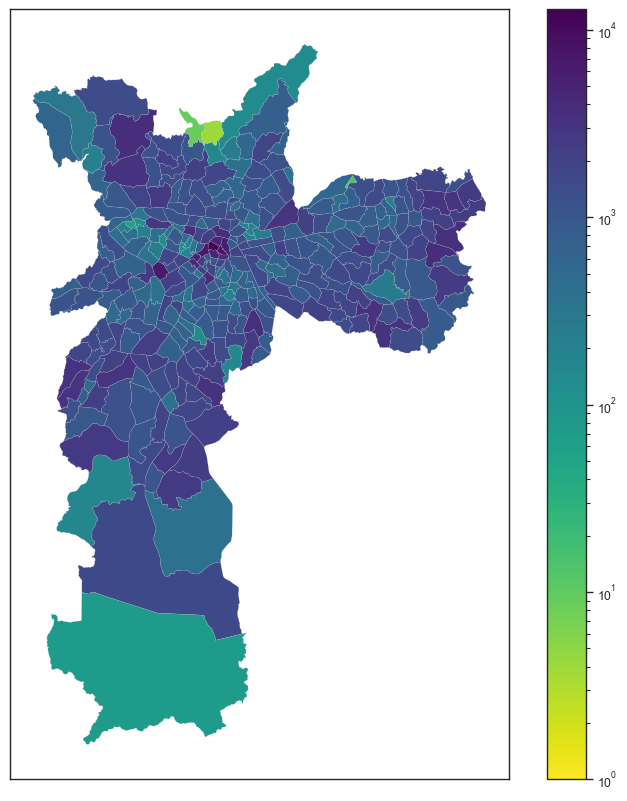

In [47]:
data.plot(
    column='crimes',
    legend=True,
    linewidth=0.1,
    edgecolor='0.8',
    figsize=(10, 10),
    cmap='viridis_r',
    norm=LogNorm(vmin=1, vmax=data['crimes'].max()),
)

plt.xticks([])
plt.yticks([])

plt.show()


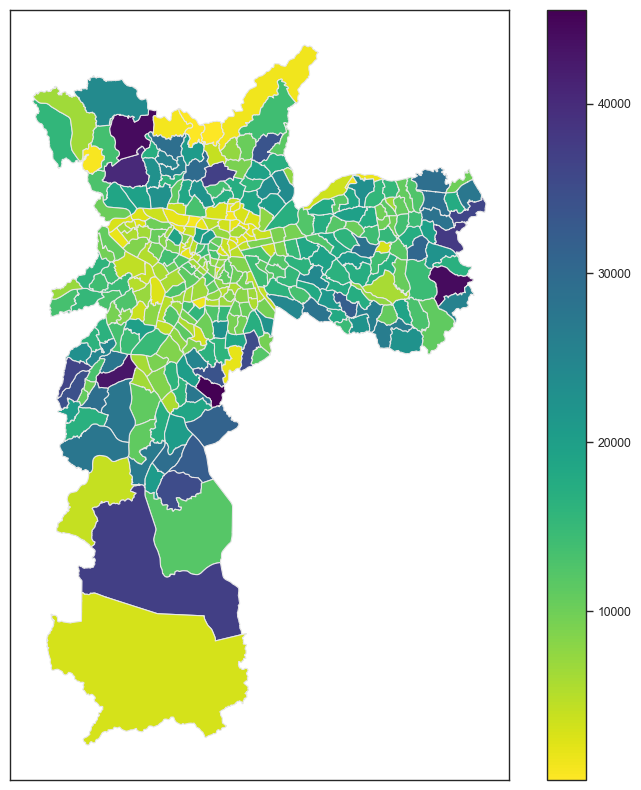

In [48]:
data.plot(
    column='V001_BASICO',
    legend=True,
    linewidth=0.8,
    edgecolor='0.9',
    figsize=(10, 10),
    cmap='viridis_r',
)

plt.xticks([])
plt.yticks([])

plt.show()


### Exploring the connection between crime and other variables

#### CENSUS Variables

In [ ]:
df = data[[
    'Area_ha_2', 'V001_ENTORNO01', 'V002_ENTORNO01', 'V003_ENTORNO01',
    'V004_ENTORNO01', 'V001_DOMICILIORENDA', 'V001_BASICO', 'V002_BASICO',
    'V001_DOMICILIO02', 'V002_DOMICILIO02', 'V001_DOMICILIO01',
    'V002_DOMICILIO01', 'V001_PESSOA01', 'V086_PESSOA02', 'V001_PESSOA03',
    'V002_PESSOA03', 'V003_PESSOA03', 'V004_PESSOA03', 'V005_PESSOA03',
    'V006_PESSOA03', 'V001_PESSOA12', 'V001_PESSOA11', 'V001_RESPONSAVEL01',
    'V001_RESPONSAVEL02', 'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA',
    'V004_DOMICILIORENDA', 'V003_BASICO', 'V005_BASICO', 'V007_BASICO',
    'V009_BASICO', 'V011_BASICO', 'crimes'
]]

df.shape

In [ ]:
ax = sns.histplot(data=df, x='V001_BASICO', bins=20, kde=True)

In [ ]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

In [ ]:
sns.boxplot(data=df, x='crimes')

In [20]:
# remove outliers based on the IQR
Q1 = df['crimes'].quantile(0.25)
Q3 = df['crimes'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['crimes'] < (Q1 - 1.5 * IQR)) | (df['crimes'] > (Q3 + 1.5 * IQR)))]

In [ ]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

In [ ]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

In [ ]:
# it seems to be a lot of multicollinearity with V001_BASICO
# Domicílios particulares permanentes ou pessoas responsáveis por domicílios particulares permanentes

corr_matrix['V001_BASICO'].sort_values(ascending=False).to_frame()[:10]

In [24]:
df = df.loc[:, (df.columns == 'V001_BASICO') | (corr_matrix['V001_BASICO'] < 0.8)]

In [ ]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

In [ ]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cols = (corr_matrix.mask(mask) > .8).any()
sns.heatmap(corr_matrix.loc[cols, cols], cmap='viridis')

In [ ]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['V005_BASICO'].sort_values(ascending=False).to_frame()[:10]

In [28]:
df = df.loc[:, (df.columns == 'V005_BASICO') | (corr_matrix['V005_BASICO'] < 0.8)]

In [ ]:
df.columns

### Regression without Spacial Lag

In [27]:
X = data.drop(columns='crimes')
y = data['crimes']

In [28]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=123,
)

#### TPOT

In [10]:
from tpot import TPOTRegressor

tpot_model = TPOTRegressor(
    max_time_mins=60*12,
    verbosity=3,
    random_state=123,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    warm_start=True,
    memory='auto',
    template='Selector-Transformer-Regressor',
)

tpot_model.fit(X, y)

30 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by RobustScaler..
_pre_test decorator: _random_mutation_operator: num_test=1 FeatureAgglomeration.__init__() got an unexpected keyword argument 'affinity'.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by FastICA..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 LassoLarsCV.__init__() got an unexpected keyword argument 'normalize'.
_pre_test decorator: _random_mutation_operator: num_test=1 FeatureAgglomeration.__init__() got an unexpected keyword argument 'affi

TPOTRegressor(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=123),
              max_time_mins=720, memory='auto', n_jobs=-1, random_state=123,
              scoring='r2', template='Selector-Transformer-Regressor',
              verbosity=3, warm_start=True)

In [66]:
models = tpot_models_dataframe(tpot_model)
#models.to_csv('..../tpot_models.csv', index=False)
models[:20]

,model,cv_score
0,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
1,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
2,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
3,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
4,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
5,GradientBoostingRegressor(RobustScaler(Varianc...,0.571964
6,GradientBoostingRegressor(OneHotEncoder(Varian...,0.570530
7,GradientBoostingRegressor(OneHotEncoder(Varian...,0.570530
8,GradientBoostingRegressor(OneHotEncoder(Varian...,0.570530
9,GradientBoostingRegressor(OneHotEncoder(Varian...,0.570530


In [19]:
tpot_model.export('../GENERATED-DATA/tpot_pipeline.py')

In [12]:
top_model = tpot_pipeline_from_string(tpot_model, models.model[0])
top_model

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.005)),
                ('onehotencoder',
                 OneHotEncoder(minimum_fraction=0.25, sparse=False)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.95, loss='huber',
                                           max_depth=4,
                                           max_features=0.7000000000000001,
                                           min_samples_leaf=4,
                                           min_samples_split=9,
                                           random_state=123,
                                           subsample=0.9000000000000001))])

#### GradientBoosting

In [16]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor

vt = VarianceThreshold(threshold=0.005)

gdb = GradientBoostingRegressor(
    alpha=0.95, loss='huber', max_depth=4,
    max_features=0.7, min_samples_leaf=4,
    min_samples_split=9, random_state=123,
    subsample=0.9
)

score = 'neg_mean_absolute_error'
df = compare_metric_with_dummy(gdb, score, vt.fit_transform(X), y, cv)
df.abs().describe()

,dummy_scores,model_scores
count,30.000000,30.000000
mean,776.288760,463.219009
std,148.891078,85.234686
min,557.618778,320.578623
25%,672.372341,407.303196
50%,759.831366,445.790310
75%,822.729683,494.844874
max,1171.059211,715.343214


#### XGBoost

In [17]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    eval_metric='mae',
    n_estimators=5000,
    learning_rate=0.001,
)

score = 'neg_mean_absolute_error'
df = compare_metric_with_dummy(xgb, score, vt.fit_transform(X), y, cv)
df.abs().describe()

,dummy_scores,model_scores
count,30.000000,30.000000
mean,776.288760,495.814746
std,148.891078,89.994571
min,557.618778,320.103360
25%,672.372341,429.613735
50%,759.831366,500.303425
75%,822.729683,555.453365
max,1171.059211,673.723788


### Regression with Spacial Lag

In [140]:
data.columns

Index(['NumeroZona', 'NomeZona', 'NumeroMuni', 'NomeMunici', 'NumDistrit',
       'NomeDistri', 'Area_ha_2', 'V001_ENTORNO01', 'V002_ENTORNO01',
       'V003_ENTORNO01', 'V004_ENTORNO01', 'V001_DOMICILIORENDA',
       'V001_BASICO', 'V002_BASICO', 'V001_DOMICILIO02', 'V002_DOMICILIO02',
       'V001_DOMICILIO01', 'V002_DOMICILIO01', 'V001_PESSOA01',
       'V086_PESSOA02', 'V001_PESSOA03', 'V002_PESSOA03', 'V003_PESSOA03',
       'V004_PESSOA03', 'V005_PESSOA03', 'V006_PESSOA03', 'V001_PESSOA12',
       'V001_PESSOA11', 'V001_RESPONSAVEL01', 'V001_RESPONSAVEL02',
       'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA', 'V004_DOMICILIORENDA',
       'V003_BASICO', 'V005_BASICO', 'V007_BASICO', 'V009_BASICO',
       'V011_BASICO', 'idade', 'grau_ins', 'sexo_Masculino',
       'estuda_2º grau/ Médio', 'estuda_Creche/ Pré-escola', 'estuda_Não',
       'estuda_Outros', 'estuda_Superior/ Universitário',
       'cd_ativi_Dona de Casa', 'cd_ativi_Em Licença Médica',
       'cd_ativi_Estudante', 'c

In [132]:
data = data.to_crs(epsg=22523) # UTM 23S
data.crs

<Projected CRS: EPSG:22523>
Name: Corrego Alegre 1970-72 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - onshore between 48°W and 42°W and south of 15°S.
- bounds: (-48.0, -25.29, -42.0, -15.0)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Corrego Alegre 1970-72
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [133]:
data = data.drop(columns=['NumeroZona', 'NomeZona', 'NumeroMuni', 'NomeMunici', 'NumDistrit',
       'NomeDistri', 'crimes'])

In [118]:
data = clean_data(data)

Original Shape: (342, 72)
Number of missing values: 154
Cleaned Shape: (338, 72)


In [119]:
from pysal.lib import weights

knn = weights.KNN.from_dataframe(data, k=5) # k=5 -> 50%
#wq  = weights.contiguity.Rook.from_dataframe(data)
#w_kernel = weights.distance.Kernel.from_dataframe(data)

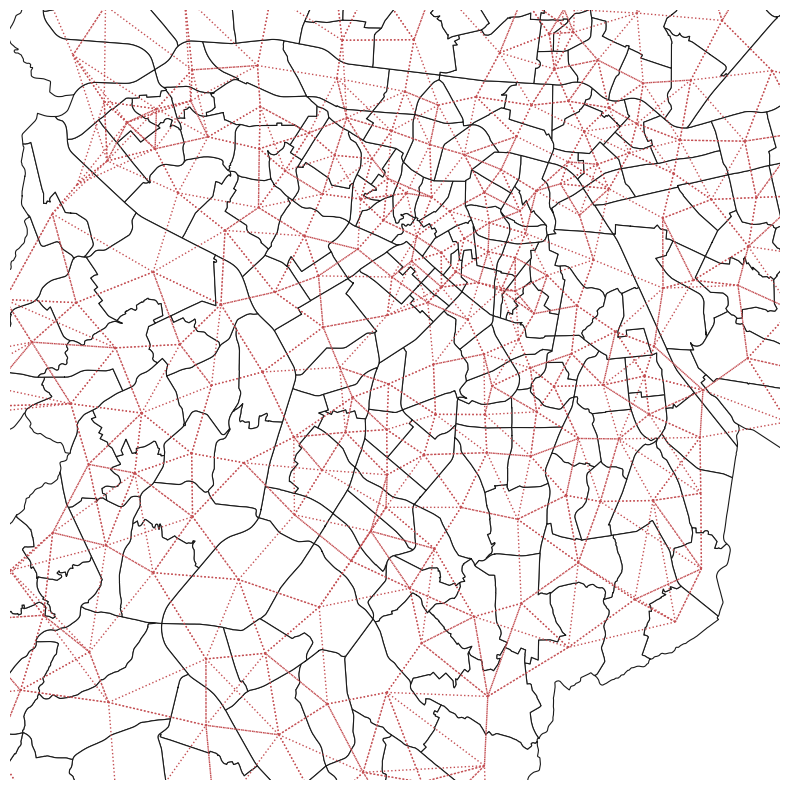

In [120]:
f, axs = plt.subplots(figsize=(10, 10))

# Plot the data with edge color and face color
data.plot(
    edgecolor="k", facecolor="w", ax=axs
)
# Plot the KNN with custom edge and node keywords
knn.plot(
    data,
    ax=axs,
    edge_kws=dict(color="r", linestyle=":", linewidth=1),
    node_kws=dict(marker="")
)
# Set axis limits and turn off the axis
axs.axis([3.2e5, 3.4e5, 7.38e6, 7.4e6])
axs.set_axis_off();

In [121]:
gdf_lag = (
    data.drop(columns='geometry')
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
    )
    .rename(
        columns=lambda c: "LAG_" + c
    )
)

TypeError: no supported conversion for types: (dtype('float64'), dtype('O'))

In [122]:
gdf_lag.shape

(338, 71)

In [ ]:
# data = data[features + ['crimes']].join(gdf_lag)
# data.columns